# On-line NIR analysis in a high density polyethene plant

Re-evaluating the NIR data used in my [M.Sc.(eng.) thesis](https://github.com/bitjungle/OpenData/blob/master/bronir2/rune-mathisen-msc-eng-thesis.pdf).

> Mathisen, R. (1999). On-line NIR analysis in a high density polyethene plant, evaluation of sampling system and optimal calibration strategy. Telemark College, Department of Technology.

The thesis deals with the calibration of an on-line near infra-red (NIR) instrument measuring on  high  density  polyethene  (HDPE)  powder.   The  goal  was  to  recommend  an  “optimal” calibration strategy for the dynamic prediction system.  The sampling system under study suffered from many weaknesses, resulting in very unstable and noisy spectra.  Variations in polymer concentration in the sampling system and a polymer film on the sampling system (sapphire) window were probably the two major problems. Another  problem  with  the  system  under  study  was  the  introduction  of  several  measurement biases  of  unknown  magnitude.   These  make  it  impossible  to  give  reliable  estimates  of  the prediction accuracy.

In the original thesis work, Matlab was used as the main analysis tool. In this reassessment I use the Python libraries Pandas, Numpy and Sklearn. The goal in this analysis is to explore the dataset and prepare for making a regression model for HDPE density at a later stage.


In [16]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter

## The dataset
The file 'bronir2-all.TXT' is a collection of 880 near infrared (NIR) spectra in the range from 1300 nm to 2500 nm. The data was collected online in a HDPE plant using a Brimrose Luminar 3030 spectrometer between 1998-07-30 and 1999-01-11. There are several response variables in the data set, including 440 density and 383 MFR 2.16 kg/190 reference measurements. 

In [17]:
all_df = pd.read_csv('bronir2-all.TXT', sep=',', na_values = ['m'])
all_df.info()
all_df.head()
#all_df[all_df.Dens > 900] # All data with valid density measurements

<class 'pandas.core.frame.DataFrame'>
Index: 880 entries, 980713-2:20 to 990108-2:421
Columns: 1208 entries, Product to 2500.0
dtypes: float64(1208)
memory usage: 8.1+ MB


,Product,Catalyst,Dens,Mfr190/2,Mfr190/5,Mfr190/21,Temp,1300.0,1301.0,1302.0,...,2491.0,2492.0,2493.0,2494.0,2495.0,2496.0,2497.0,2498.0,2499.0,2500.0
980713-2:20,8.0,0.0,936.099976,NaN,0.97,14.1,NaN,0.001753,0.001767,0.001800,...,0.263289,0.276664,0.292457,0.312405,0.336896,0.367879,0.405578,0.451296,0.506242,0.571901
980713-2:64,8.0,0.0,938.900024,NaN,0.84,11.9,NaN,-0.007259,-0.007261,-0.007240,...,0.326356,0.343830,0.363631,0.388610,0.420130,0.461255,0.511990,0.575668,0.651195,0.739630
980713-2:92,8.0,0.0,NaN,NaN,NaN,12.3,NaN,0.072211,0.072389,0.072569,...,0.262145,0.274324,0.288954,0.307731,0.329331,0.353835,0.379205,0.405775,0.431037,0.456781
980713-2:116,8.0,0.0,938.599976,NaN,NaN,11.4,NaN,0.008682,0.008683,0.008708,...,0.383956,0.411971,0.446242,0.489790,0.544611,0.613561,0.697944,0.801592,0.923604,1.065754
980713-2:165,8.0,0.0,938.299988,NaN,0.87,14.0,NaN,0.016686,0.016687,0.016707,...,0.433395,0.461214,0.495580,0.537592,0.592171,0.659849,0.746200,0.851635,0.981991,1.136913


From the thesis work it is known that the spectrum above approximately 2120 nm is very noisy. Removing it from the regression models gives more robust models.

In [18]:
wl_start = 1300 # Starts at column index 7 in the dataframe
wl_end = 2120   # Very noisy data above 2120 nm
X = all_df.values[:,7:(wl_end-wl_start+7)].astype('float32') # NIR spectrum
Xmean = np.mean(X, axis=0)                   # Mean spectrum (all data)
dens = all_df.values[:,2].astype('float32')  # measured density from lab
prod = all_df.values[:,0].astype('int32')    # Product type
cat = all_df.values[:,1].astype('int32')     # Catalyst type
wl = range(wl_start, wl_end)                 # NIR wavelength range


Plotting the raw NIR data reveals the massive noise problem in this dataset.

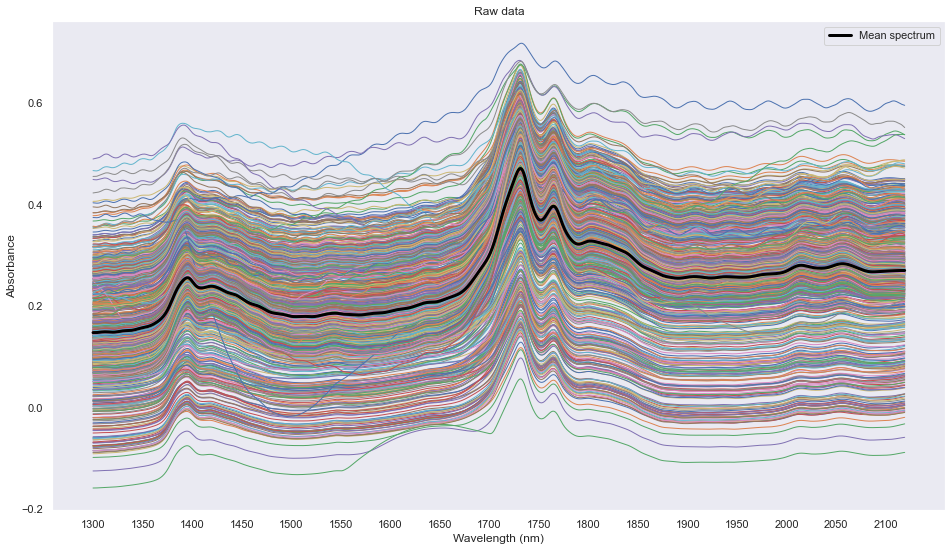

In [19]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=[16, 9])
for n in range(0, len(X)):
    plt.plot(wl, X[n], linewidth=1)
plt.plot(wl, Xmean, color="black", linewidth=3, label="Mean spectrum")
plt.title('Raw data')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')
plt.xticks([t for t in range(wl_start, wl_end, 50)])
plt.grid()
plt.legend()
plt.show()


## Pre-processing
### SNV

Standard Normal Variate (SNV) method performs a normalization of the spectra that consists in subtracting each spectrum by its own mean and dividing it by its own standard deviation. After SNV, each spectrum will have a mean of 0 and a standard deviation of 1.

The mean response is calculated as:

$$ \bar{x}_{i} = \sum_{j=1}^{p} \mathbf{X}_{i,j} $$

The standard deviation is calculated as:

$$ \sigma_{i} = \sqrt{\frac
            {\sum_{j=1}^{p}\left(\mathbf{X}_{i,j} - \bar{x}_{i}\right)^{2}}
            {p-1}}
$$

The corrected spectrum is then calculated as:

$$ 
\mathbf{X}_{i,SNV} = \frac
{(\mathbf{X}_{i} - \bar{x}_{i})}{\sigma_{i}}
$$

SNV attempts at making all spectra comparable in terms of intensities (or absorbance level). It can be useful to correct spectra for changes in optical path length and light scattering (it is assumed that the standard deviation of the spectra represents well these changes). 

SNV will be used in preprocessing of the NIR data here. Defining a SVN function:

In [20]:
def snv(X):
    '''Standard Normal Variate'''
    # Define a new array and populate it with the corrected data  
    Xsnv = np.zeros_like(X)
    Xmean = np.mean(X, axis=1)
    Xstd = np.std(X, axis=1)
    for i in range(X.shape[0]):
        Xsnv[i,:] = (X[i,:] - Xmean[i]) / Xstd[i]
    return Xsnv

Xsnv = snv(X)
Xsvn_mean = np.mean(Xsnv, axis=0)                   # Mean spectrum (all data)

Let's plot the NIR spectra again to get a visual representation of the effect on applying SNV.

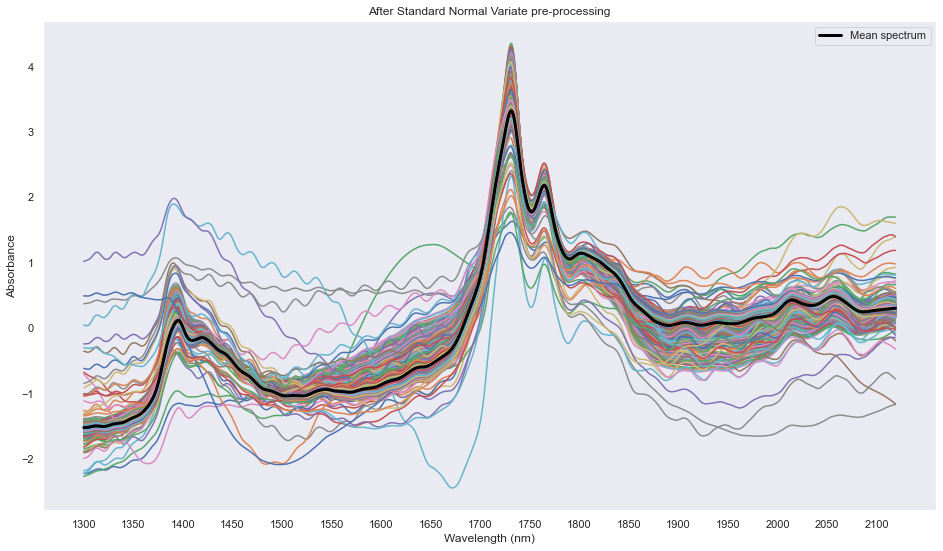

In [21]:
plt.figure(figsize=[16, 9])
for n in range(0, len(Xsnv)):
    plt.plot(wl, Xsnv[n])
plt.plot(wl, Xsvn_mean, color="black", linewidth=3, label="Mean spectrum")
plt.title('After Standard Normal Variate pre-processing')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')
plt.xticks([t for t in range(wl_start, wl_end, 50)])
plt.grid()
plt.legend()
plt.show()

### Outlier detection and removal
I am applying a very simple outlier detection below, there is plenty of possibilities here to do something more sofisticated. Calculating eclidian distance from mean, and remove all spectra above a given threshold.

In [22]:
euclid_dist = []
euclid_dist_threshold = 5

for s in Xsnv:
    euclid_dist.append(math.dist(Xsvn_mean, s))

outliers = np.where(np.array(euclid_dist) > euclid_dist_threshold)

# Delete outlier spectra, re-calculate mean spectrum
Xsnv_clean = np.delete(Xsnv, outliers, axis=0)
prod_clean = np.delete(prod, outliers)
cat_clean = np.delete(cat, outliers)
dens_clean = np.delete(dens, outliers)



Let's plot the dataset again, now with the most obvious outlier data removed.

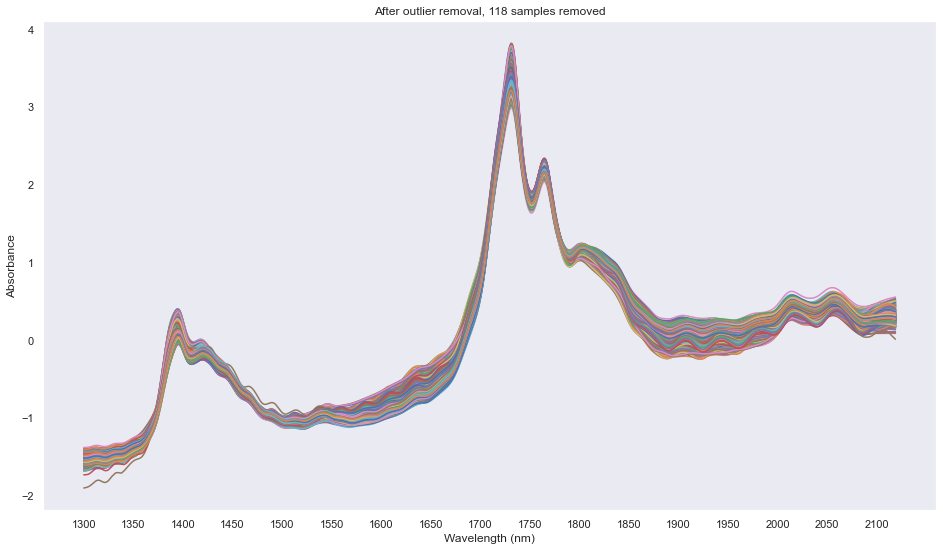

In [23]:

plt.figure(figsize=[16, 9])
for n in range(0, len(Xsnv_clean)):
    plt.plot(wl, Xsnv_clean[n])
plt.title('After outlier removal, {} samples removed'.format(len(outliers[0])))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')
plt.xticks([t for t in range(wl_start, wl_end, 50)])
plt.grid()
plt.show()

### Smoothing and derivation

An effective way of removing baseline-effects is to use derivatives of the original spectra for calibration.  The first derivative will remove an offset, and the second derivative will remove both a slope and an offset. 

I am using the Savintzky-Golay algoritm to do data smoothing and calculating the second derivative, using a 49 point data window and fitting a second order polynom.

In [24]:
# Second derivative
Xpre = savgol_filter(Xsnv_clean, 49, polyorder = 2, deriv=2, mode='mirror')


Let's plot the second derivative spectra.

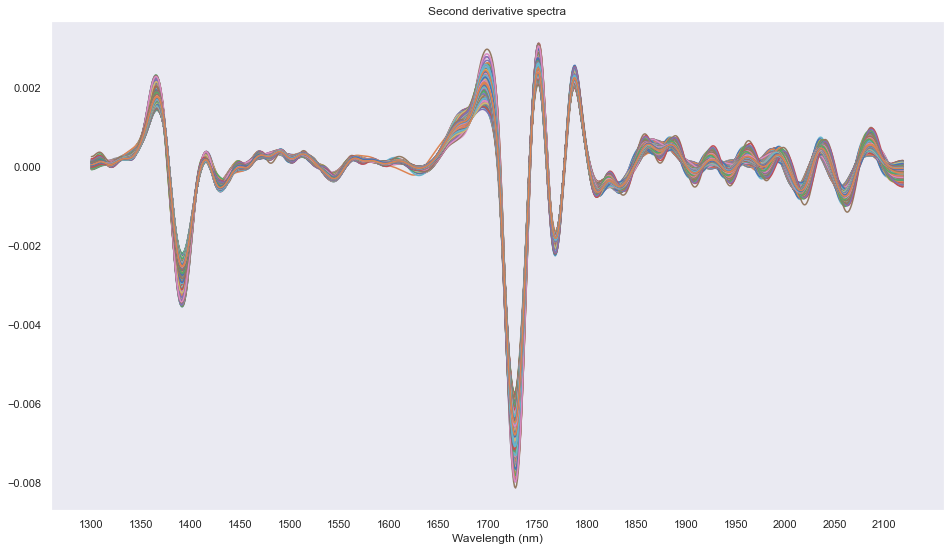

In [25]:
plt.figure(figsize=[16, 9])
for n in range(0, len(Xpre)):
    plt.plot(wl, Xpre[n])
plt.xticks([t for t in range(wl_start, wl_end, 50)])
plt.title('Second derivative spectra')
plt.xlabel('Wavelength (nm)')
plt.grid()
plt.show()

## PCA

Principal Component Analysis (PCA) provides an approximation of a data matrix $X$, in terms of the product of scores $T$ and loadings $P$.  The purpose is to express the main information in the variables by a lower number of variables, called the principal components (PC) of $X$.  This is possible because in many cases the $X$-variables are expected to be collinear.  This collinearity means that the data matrix $X$ will have some dominating types of variability that carry most of the available information.  The PCA algorithm performs a projection down on a subspace in such a way that each of these “hidden” directions becomes anew variable.  For a mean centered data matrix, we have:

$$ \tilde X = \hat T \hat P^T + E $$

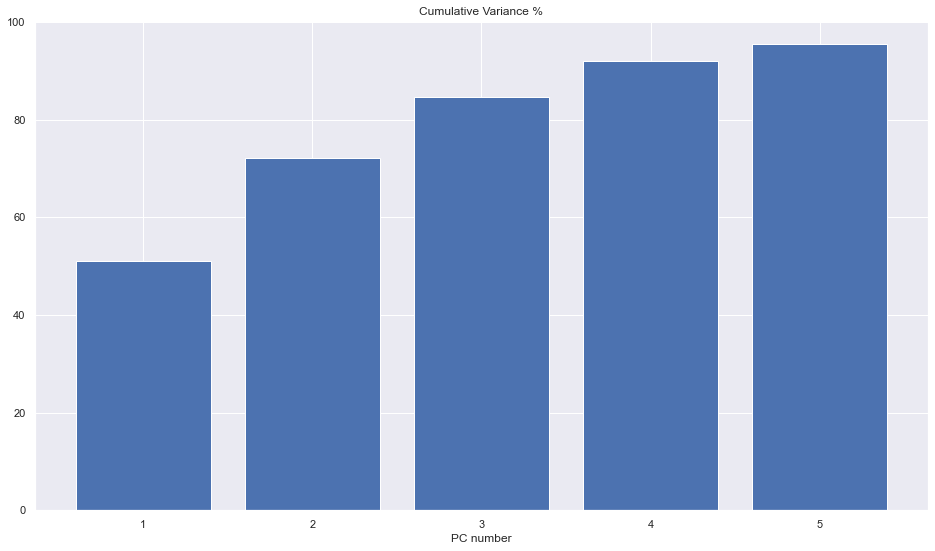

In [26]:
# https://nirpyresearch.com/nir-data-correlograms-seaborn-python/
pca = PCA(n_components=5)
# Fit the model with X and apply the dimensionality reduction on X.
Xpca = pca.fit_transform(Xpre)

plt.figure(figsize=[16, 9])
#plt.plot(np.cumsum(pca.explained_variance_ratio_)*100,'-o')
plt.bar([1, 2, 3, 4, 5], np.cumsum(pca.explained_variance_ratio_)*100)
plt.title("Cumulative Variance %")
plt.xlabel("PC number")
plt.show()

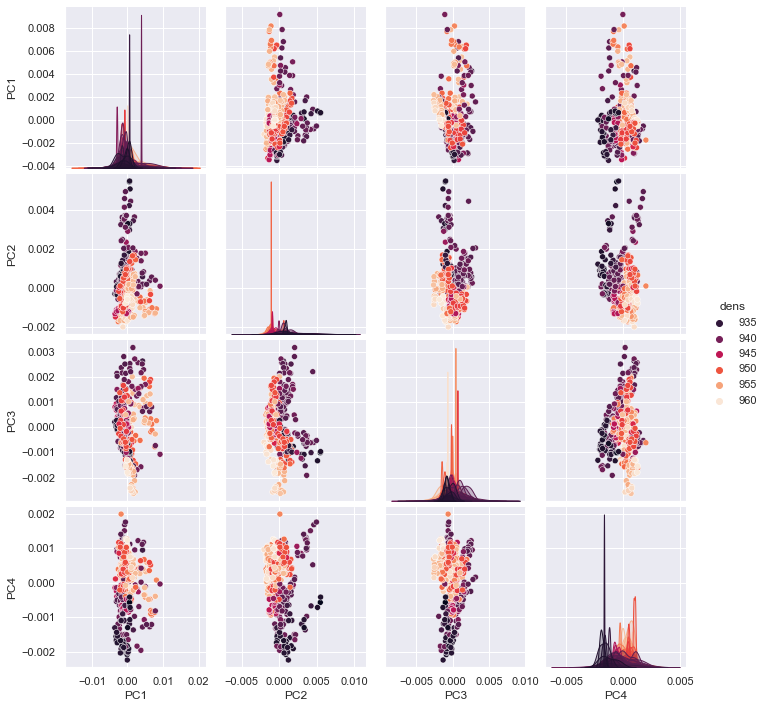

In [27]:
Xpca_df = pd.DataFrame(Xpca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
#sns.pairplot(Xpca_df)
Xpca_df['prod'] = prod_clean
Xpca_df['cat'] = cat_clean
Xpca_df['dens'] = dens_clean
sns.pairplot(Xpca_df, vars=['PC1', 'PC2', 'PC3', 'PC4'], hue='dens', palette='rocket')
#sns.pairplot(Xpca_df, kind='kde')

<AxesSubplot:>

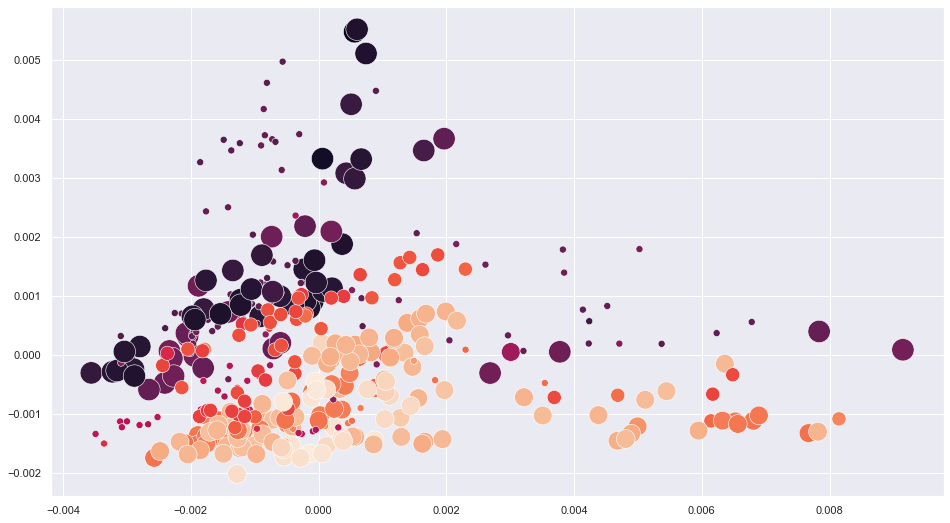

In [28]:
sns.set(rc={"figure.figsize":(16, 9)})
# Experimental 4D plot. Dot size corresponds to catalyst type, dot color is density
sns.scatterplot(x=Xpca_df.PC1.values, y=Xpca_df.PC2.values, hue=Xpca_df.dens, size=Xpca_df.cat, sizes=(50, 500), palette='rocket', legend=False)

Text(0.5, 0, 'Wavelength (nm)')

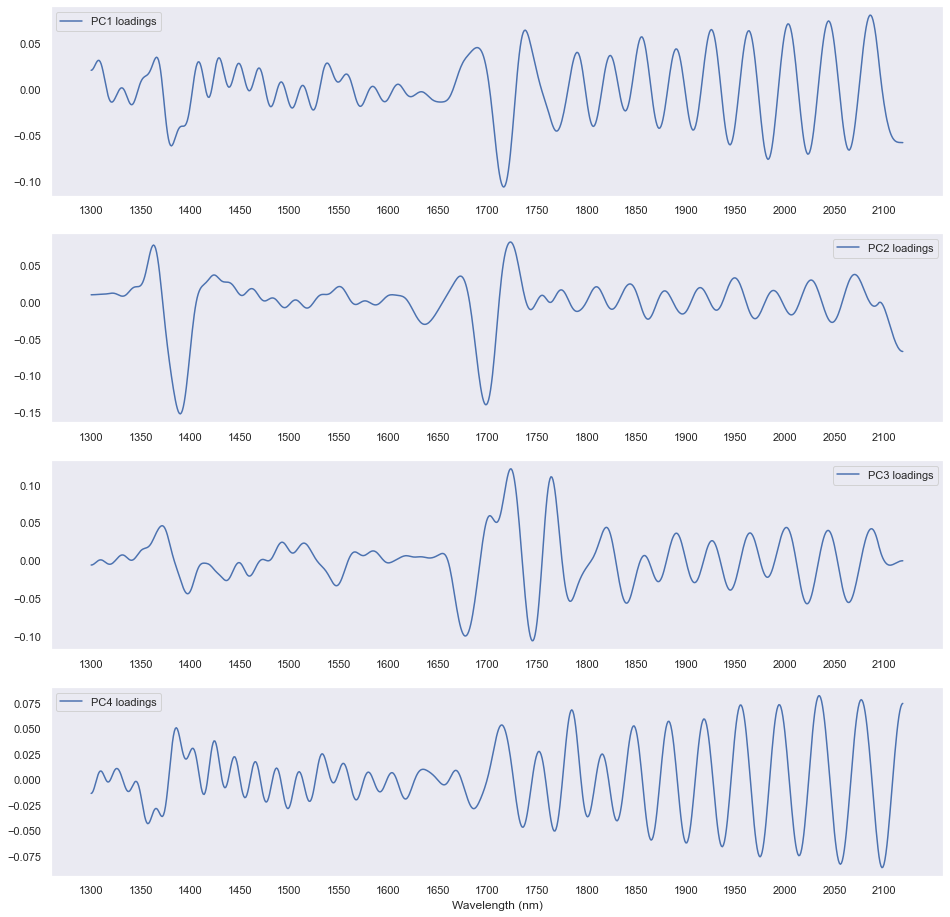

In [29]:
fig = plt.figure(figsize=[16, 16])
for i in range(1, 5):
    ax = fig.add_subplot(4, 1, i)
    ax.plot(wl, pca.components_.T[:,i], label="PC{} loadings".format(i))
    ax.legend()
    ax.grid()
    plt.xticks([t for t in range(wl_start, wl_end, 50)])

plt.xlabel('Wavelength (nm)')


## Analysis

It was shown in the thesis work that what appears to be an oscillating signal in the spectra was caused by a thin polymer film/layer on the sapphire window in the sampling system.  It is  known that a thin sample with parallel sides will cause interference fringes in the spectrum. These features are clearly visible in the loading vectors, and also in many of the raw NIR spectra. This signal is very prominent in the loading vectors above 1750 nm.

Other features in the loading vectors may be matched against known NIR bands for LLDPE. It is assumed that they also apply to HDPE. See table below.

![Assignments of NIR bands in LLDPE](nir-bands-lldpe.png)